------ konec pripojovani souboru z disku

In [1]:
import matplotlib.pyplot as plt
import src.libs.ikrlib as il
import numpy as np
from numpy.random import randint
import scipy
from glob import glob

### How to run
- there are variables, where you need to set proper data
- - MAIN_PATH - folder with folders of target_dev, non_target_dev, target_train and non_target_train. With that variable set, everything should be trained and tested properly 
- in section **Test the GMM on your data** you need to set up PATH with records that will be tested with **GMM**, and OUTPUT where results will be loaded
- in section **Evaluate custom data on trained model** you need to setup the same variables as mentioned right above

In [2]:
# set path for data (folder, where are folders target_dev,...)
MAIN_PATH="data"

In [3]:
# load all files from directories
target_dev = list(il.wav16khz2mfcc(MAIN_PATH+'/target_dev/').values())
target_train = list(il.wav16khz2mfcc(MAIN_PATH+'/target_train/').values())
non_target_dev = list(il.wav16khz2mfcc(MAIN_PATH+'/non_target_dev/').values())
non_target_train = list(il.wav16khz2mfcc(MAIN_PATH+'/non_target_train/').values())

Processing file:  data/target_dev/m430_03_p01_i0_0.wav
Processing file:  data/target_dev/m430_03_p02_i0_0.wav
Processing file:  data/target_dev/m430_03_p03_i0_0.wav
Processing file:  data/target_dev/m430_03_p04_i0_0.wav
Processing file:  data/target_dev/m430_03_p05_i0_0.wav
Processing file:  data/target_dev/m430_03_r06_i0_0.wav
Processing file:  data/target_dev/m430_03_r07_i0_0.wav
Processing file:  data/target_dev/m430_03_r08_i0_0.wav
Processing file:  data/target_dev/m430_03_r09_i0_0.wav
Processing file:  data/target_dev/m430_03_r10_i0_0.wav
Processing file:  data/target_train/m430_01_p01_i0_0.wav
Processing file:  data/target_train/m430_01_p02_i0_0.wav
Processing file:  data/target_train/m430_01_p03_i0_0.wav
Processing file:  data/target_train/m430_01_p04_i0_0.wav
Processing file:  data/target_train/m430_01_p05_i0_0.wav
Processing file:  data/target_train/m430_01_r06_i0_0.wav
Processing file:  data/target_train/m430_01_r07_i0_0.wav
Processing file:  data/target_train/m430_01_r08_i0_

In [4]:
target_train = np.vstack(target_train)
non_target_train = np.vstack(non_target_train)

dim = target_train.shape[1]
dim2 = non_target_train.shape[1]
print(target_train.shape)
print(dim2)

(27252, 13)
13


PCA (mainly overtaken from SUR example project *demo_genderID.py*)
===

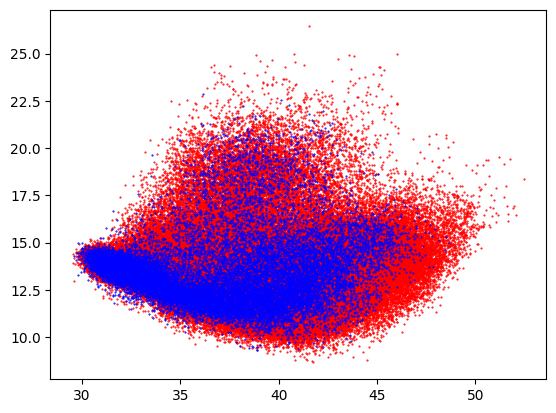

In [5]:
# PCA analysis
cov_tot = np.cov(np.vstack([target_train, non_target_train]).T, bias=True)
# division was obtained when used 5 last vectors, but still it is bad
d, e = scipy.linalg.eigh(cov_tot, subset_by_index=[dim-2, dim-1])

target_train_pca = target_train.dot(e)
non_target_train_pca = non_target_train.dot(e)
plt.plot(non_target_train_pca[:,1], non_target_train_pca[:,0], 'r.', ms=1)
plt.plot(target_train_pca[:,1], target_train_pca[:,0], 'b.', ms=1)
plt.show()

LDA (mainly overtaken from SUR example project *demo_genderID.py*)
===

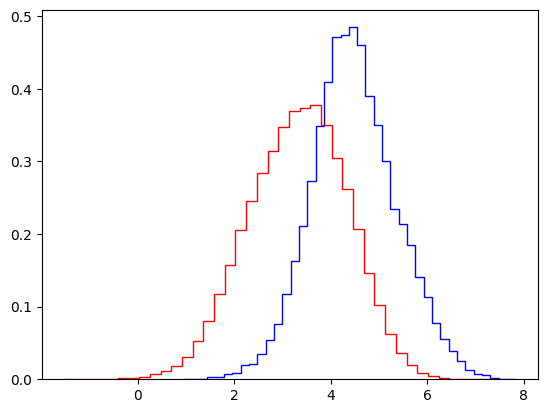

In [6]:
# LDA analysis
n_target = len(target_train)
n_non_target = len(non_target_train)
cov_wc = (n_target*np.cov(target_train.T, bias=True) + n_non_target*np.cov(non_target_train.T, bias=True)) / (n_target + n_non_target)
cov_ac = cov_tot - cov_wc
d, e = scipy.linalg.eigh(cov_ac, cov_wc, eigvals=(dim-1, dim-1))

plt.figure()
junk = plt.hist(target_train.dot(e), 40, histtype='step', color='b',density=True)
junk = plt.hist(non_target_train.dot(e), 40, histtype='step', color='r',density=True)
plt.show()

In [7]:
# do tests on LDA
# Lets define uniform a-priori probabilities of classes:
P_target = 0.5
P_non_target = 1 - P_target
test_set=non_target_dev

score=[]
mean_target, cov_target = il.train_gauss(target_train)
mean_non_target, cov_non_target = il.train_gauss(non_target_train)
for tst in test_set:
    ll_target = il.logpdf_gauss(tst, mean_target, cov_target)
    ll_non_target = il.logpdf_gauss(tst, mean_non_target, cov_non_target)
    score_sum = (sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target))
    score.append(score_sum > 0 if test_set==target_dev else score_sum < 0)
print(sum(score) / len(score))

# Run recognition with 1-dimensional LDA projected data
score=[]
mean_target, cov_target = il.train_gauss(target_train.dot(e))
mean_non_target, cov_non_target = il.train_gauss(non_target_train.dot(e))
for tst in test_set:
    ll_target = il.logpdf_gauss(tst.dot(e), mean_target, np.atleast_2d(cov_target))
    ll_non_target = il.logpdf_gauss(tst.dot(e), mean_non_target, np.atleast_2d(cov_non_target))
    score_sum = (sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target))
    score.append(score_sum > 0 if test_set==target_dev else score_sum < 0)
print(sum(score) / len(score))


0.8833333333333333
0.85


GMM (mainly overtaken from SUR example project *demo_genderID.py*)
===

In [8]:
P_target = 0.5
P_non_target = 1 - P_target

# Decide for number of gaussian mixture components used for the target data
num_comp_target = 3
MUs_target  = target_train[randint(1, len(target_train), num_comp_target)]
COVs_target = [np.var(target_train, axis=0)] * num_comp_target
Ws_target = np.ones(num_comp_target) / num_comp_target;


# Initialize parameters of non target data
num_comp_non_target = 4
MUs_non_target  = non_target_train[randint(1, len(non_target_train), num_comp_non_target)]
COVs_non_target = [np.var(non_target_train, axis=0)] * num_comp_non_target
Ws_non_target   = np.ones(num_comp_non_target) / num_comp_non_target;

# Run 30 iterations of EM algorithm to train the two GMMs from target and non target data
target_ttl_arr = []
non_target_ttl_arr = []

for jj in range(100):
  [Ws_target, MUs_target, COVs_target, TTL_target] = il.train_gmm(target_train, Ws_target, MUs_target, COVs_target);
  [Ws_non_target, MUs_non_target, COVs_non_target, TTL_non_target] = il.train_gmm(non_target_train, Ws_non_target, MUs_non_target, COVs_non_target);
  target_ttl_arr.append(TTL_target)
  non_target_ttl_arr.append(TTL_non_target)
  print('Iteration:', jj, ' Total log-likelihood:', TTL_target, 'for target;', TTL_non_target, 'for non target')

# print(target_ttl_arr)
# plt.plot(target_ttl_arr,label='Log-likelihood of target train data')
# plt.plot(non_target_ttl_arr,label='Log-likelihood of non target train data')
# plt.legend()
# plt.show()

# perform testing
score=[]
for tst in target_dev:
    ll_target = il.logpdf_gmm(tst, Ws_target, MUs_target, COVs_target)
    ll_non_target = il.logpdf_gmm(tst, Ws_non_target, MUs_non_target, COVs_non_target)
    score_sum = (sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target))
    score.append(score_sum)

print(score)
# print(sum(score)/len(target_dev))

score=[]
for tst in non_target_dev:
    ll_target = il.logpdf_gmm(tst, Ws_target, MUs_target, COVs_target)
    ll_non_target = il.logpdf_gmm(tst, Ws_non_target, MUs_non_target, COVs_non_target)
    score_sum = (sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target))
    score.append(score_sum)
print(score)

# print(sum(score)/len(non_target_dev))

Iteration: 0  Total log-likelihood: -401252.48555072275 for target; -2968338.5510253264 for non target
Iteration: 1  Total log-likelihood: -327580.2955679735 for target; -2464524.860081344 for non target
Iteration: 2  Total log-likelihood: -303900.7037858023 for target; -2315088.229805461 for non target
Iteration: 3  Total log-likelihood: -294897.8696371458 for target; -2243833.1887768116 for non target
Iteration: 4  Total log-likelihood: -289308.01717832463 for target; -2224043.8802571385 for non target
Iteration: 5  Total log-likelihood: -286815.23454368935 for target; -2216430.448039945 for non target
Iteration: 6  Total log-likelihood: -285801.4181527552 for target; -2211833.340056057 for non target
Iteration: 7  Total log-likelihood: -285344.142119853 for target; -2208870.071609106 for non target
Iteration: 8  Total log-likelihood: -285109.2178345436 for target; -2207048.5915389527 for non target
Iteration: 9  Total log-likelihood: -285001.88332795026 for target; -2205957.94174942

## Test the GMM on your data

In [9]:
# insert path to your data here (folder with .wav files)
PATH="SUR_projekt2023-2024_eval/eval/"
# insert file name for the result printout
OUT_FILE="voice_gmm"

#======================================
#======================================

# parsing of the data and running test of the model
test_set = il.wav16khz2mfcc(PATH).values()

# load file names
file_names = []
for f in glob(PATH + '/*.wav'):
  file_names.append(f.removesuffix('.wav'))

In [ ]:
# create out file
f = open(OUT_FILE, 'w')

sum_of_speaker = 0
for (tst,f_name) in zip(test_set,file_names):
  ll_target = il.logpdf_gmm(tst, Ws_target, MUs_target, COVs_target)
  ll_non_target = il.logpdf_gmm(tst, Ws_non_target, MUs_non_target, COVs_non_target)
  soft_score = (sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target))
  hard_decission = int(soft_score > 0)
  sum_of_speaker += hard_decission
  f.write(f'{f_name.split("/")[len(f_name.split("/"))-1]} {soft_score} {hard_decission}\n')

NEURAL NETWORK
===

In [10]:
# build simple neural network
import torch
import torch.nn as nn
import numpy as np
import src.libs.ikrlib as il
import scipy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from glob import glob
import src.trainmodel as tm
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
# load spectograms of files, also all wav files are shortened for the first 1.5s
max_length = 0
max_freq = 0

start_idx_of_signal = int(16000*1.5)
nn_target_dev = []
for f in glob(MAIN_PATH+'/target_dev/' + '/*.wav'):
    fs,s = il.wavfile.read(f)
    s = s[start_idx_of_signal:]
    f,t,sg = scipy.signal.spectrogram(s,fs)
    max_length = len(t) if len(t) > max_length else max_length
    max_freq = len(f) if len(f) > max_freq else max_freq
    nn_target_dev.append(sg)

nn_target_train = []
for f in glob(MAIN_PATH+'/target_train/' + '/*.wav'):
    fs,s = il.wavfile.read(f)
    s = s[start_idx_of_signal:]
    _,t,sg = scipy.signal.spectrogram(s,fs)
    max_length = len(t) if len(t) > max_length else max_length
    max_freq = len(f) if len(f) > max_freq else max_freq
    nn_target_train.append(sg)

nn_non_target_dev = []
for f in glob(MAIN_PATH+'/non_target_dev/' + '/*.wav'):
    fs,s = il.wavfile.read(f)
    s = s[start_idx_of_signal:]
    _,t,sg = scipy.signal.spectrogram(s,fs)
    max_length = len(t) if len(t) > max_length else max_length
    max_freq = len(f) if len(f) > max_freq else max_freq
    nn_non_target_dev.append(sg)

nn_non_target_train = []
for f in glob(MAIN_PATH+'/non_target_train/' + '/*.wav'):
    fs,s = il.wavfile.read(f)
    s = s[start_idx_of_signal:]
    _,t,sg = scipy.signal.spectrogram(s,fs)
    max_length = len(t) if len(t) > max_length else max_length
    max_freq = len(f) if len(f) > max_freq else max_freq
    nn_non_target_train.append(sg)


### NEURAL NETWORK

In [12]:
# pad spectograms for each train data (and combine them together)
padded_spectrograms = []
for data in [nn_non_target_train,nn_target_train]:
    for spec in data:
        padded_spec = np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant')
        padded_spectrograms.append(padded_spec)

# convert padded train data to
padded_spectrograms = np.array(padded_spectrograms)

In [13]:
# compute standard deviation and mean for normalization of spectrograms
spec_mean = np.mean(padded_spectrograms)
spec_std = np.std(padded_spectrograms)
padded_spectrograms = (padded_spectrograms - spec_mean) / spec_std
print(f"Spectogram mean is {spec_mean} and standard deviation is {spec_std}")

Spectogram mean is 12.048683166503906 and standard deviation is 687.1751708984375


In [14]:
# create labels (we know that non target and target data goes one by one as we loaded them two cells before)
labels_non_target = np.linspace(0,0,len(nn_non_target_train))
labels_target = np.linspace(1,1,len(nn_target_train))
labels_for_train = np.concatenate((labels_non_target,labels_target),axis=None)

In [15]:
# prepare data as input for neural network
spectrograms_tensor = torch.Tensor(padded_spectrograms).to(device)
labels_tensor = torch.LongTensor(labels_for_train).to(device)
dataset = TensorDataset(spectrograms_tensor.unsqueeze(1), labels_tensor)

In [16]:
# build the model
class CNN(nn.Module):
    def __init__(self,height,width,num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * (height // 4) * (width // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)  # num_classes is the number of output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten feature maps
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

_, height, width = padded_spectrograms.shape
# Initialize the CNN model
# del model
model = CNN(height,width,2).to(device)
batch_size = 32

In [ ]:
# delete the model if necessary for next training
# del model

### Train function (best setup lr=0.0001, weight_decay=0.005, grad_clip=0.0005)

In [17]:

# define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([20/152,132/152])).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.005)

# create DataLoader for batch processing
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses_overall = []

# training
num_epochs = 100
for epoch in range(num_epochs):
    losses = []
    for batch_inputs, batch_labels in dataloader:
        # forward
        outputs = model(batch_inputs)
        
        # torch.save(model.state_dict(), PATH)
        # loss
        loss = criterion(outputs, batch_labels)
        if epoch > 0 : nn.utils.clip_grad_value_(model.parameters(), 0.0005)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    losses_overall.append(np.mean(losses))
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses)}')

# plot graph
plt.plot(np.arange(0,num_epochs,1),losses_overall)
plt.title('Loss function')
plt.show()

Epoch 1/100, Loss: 0.6947254300117492


KeyboardInterrupt: 

In [ ]:
# save currently trained model
# PATH="nn_model_0.tn"
# torch.save(model.state_dict(), PATH)

#### Evaluate the model on test data

In [18]:
# testing
# pad spectograms for each test data
ps_target_dev = []
for spec in nn_target_dev:
        padded_spec = np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant')
        ps_target_dev.append(padded_spec)

ps_non_target_dev = []
for spec in nn_non_target_dev:
        padded_spec = np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant')
        ps_non_target_dev.append(padded_spec)

# convert padded test data to array
ps_target_dev = np.array(ps_target_dev)
ps_non_target_dev = np.array(ps_non_target_dev)

# target dev spectrograms tensor
td_tensor = torch.Tensor(ps_target_dev)
sum_pred_td = 0
for t in td_tensor:
    input_spec = t.unsqueeze(0).unsqueeze(0).to(device)
    ev = model(input_spec)
    pred_class = torch.argmax(ev).to(device)
    sum_pred_td += pred_class.int()
print(f"Success rate on target_dev: {sum_pred_td/len(td_tensor)}")

# target dev spectrograms tensor
non_td_tensor = torch.Tensor(ps_non_target_dev)
sum_pred_td = 0
for t in non_td_tensor:
    input_spec = t.unsqueeze(0).unsqueeze(0).to(device)
    ev = model(input_spec)
    pred_class = torch.argmax(ev).to(device)
    sum_pred_td += pred_class.int()
print(f"Success rate on non_target_dev: {1-sum_pred_td/len(non_td_tensor)}")

Success rate on target_dev: 0.5
Success rate on non_target_dev: 0.8500000238418579


### Evaluate custom data on trained model

In [19]:
import os
# set path for output file
OUTPUT="data/results/voice_convnn"
# prepare data
PATH="SUR_projekt2023-2024_eval/eval"
max_length=3517 # DO NOT CHANGE, the max length of an input

# ************************************************************

# load spectrograms of input wavs from given folder
start_idx_of_signal = int(16000*1.5)
nn_real_data = []
file_names=[]
for _,_,files in os.walk(PATH):# glob(PATH + '/*.wav'):
    for file in files:
        if (file.endswith('.wav')):
            file_names.append(file.replace('.wav',''))
            # compute the spectrogram
            fs,s = il.wavfile.read(os.path.join(PATH,file))
            s = s[start_idx_of_signal:]
            f,t,sg = scipy.signal.spectrogram(s,fs)
            nn_real_data.append(sg[:,:3517])


# pad the spectrograms
ps_real_data = []
for spec in nn_real_data:
    padded_spec = np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant')
    # padded_spec = (padded_spec - np.mean(padded_spec)) / np.std(padded_spec)
    ps_real_data.append(padded_spec)

# convert padded spectrograms to an array and then to tensor
ps_real_data=np.array(ps_real_data)
td_tensor_real_data = torch.Tensor(ps_real_data)

# ***************************** go through the data and evaluate them *****************************

f = open(OUTPUT,'w')
# loop through the data write results to the file
f_idx = 0

# target dev spectrograms tensor
# td_tensor = torch.Tensor(ps_real_data)
sum_pred_td = 0
for t in td_tensor_real_data:
    input_spec = t.unsqueeze(0).unsqueeze(0).to(device)
    output = model(input_spec)

    f.write(f'{file_names[f_idx]} {output.to('cpu').detach().numpy()[0][output.argmax()]} {output.argmax()}\n')
    sum_pred_td += output.argmax()
    f_idx +=1

f.close()